# 100% RE by 2050 and the Effects of Lifetime and Recycling

Comparison case using the functions in PV ICE to compare how PV module lifetime and PV module recycling effect the energy transition to 100% clean energy by 2050.





![Folder 15 vs 50 year Module](../images_wiki/2_15vs50Overview.PNG)

WORDS WORDS WORDS


In [1]:
import PV_ICE
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
from IPython.display import display
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (12, 8)

import os
from pathlib import Path

PV_ICE.__version__

'v0.2.0+62.g7adce2b.dirty'

In [2]:
testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP' / 'SFs_LifeVSRecycle')
inputfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')
materialsfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
print ("Your simulation will be stored in %s" % testfolder)
print("Your simulation input data will be written/read from %s" % inputfolder)
print("Material files will be from %s" % materialsfolder)

Your simulation will be stored in C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\SFs_LifeVSRecycle
Your simulation input data will be written/read from C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP
Material files will be from C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\baselines


In [3]:
if not os.path.exists(testfolder):
    os.makedirs(testfolder)

# File Preparation

First, we load the Module Baseline. Will be used later to populate all the columns other than 'new_Installed_Capacity_[MW]' which will be supplied by the REEDS model. Unlike the SF simulations, this analysis will use PV ICE developed baselines.

NOTE: this section of code should only need to be run once to populate data, and again anytime the ReeDS file is updated.

In [4]:
rtest = PV_ICE.Simulation(name='Sim1', path=inputfolder)
rtest.createScenario(name='test', file=r'..\baselines\baseline_modules_US.csv')
baseline = rtest.scenario['test'].data
baseline = baseline.drop(columns=['new_Installed_Capacity_[MW]'])
baseline.set_index('year', inplace=True)
baseline.index = pd.PeriodIndex(baseline.index, freq='A')  # A -- Annual
#baseline.head(5)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP


Drop 1995 through 2009 because SF projections begin in 2010. Technically this neglects ~1.5 GW of installs from 1995 through 2009.

In [5]:
baseline.drop(baseline.loc['1995':'2009'].index, inplace=True)

Now we load the ReEDS simulation output, i.e. the Solar Futures projections with PCA regions, States, and Scenarios. Note that this is stored outside of the PV ICE folder and therefore not publicly available on github

In [6]:
reedsFile = str(Path().resolve().parent.parent.parent / 'December Core Scenarios ReEDS Outputs Solar Futures v3a.xlsx')
print ("Input file is stored in %s" % reedsFile)

Input file is stored in C:\Users\hmirletz\Documents\GitHub\December Core Scenarios ReEDS Outputs Solar Futures v3a.xlsx


In [7]:
REEDSInput = pd.read_excel(reedsFile, sheet_name="new installs PV")
#NEED TO CHECK THAT AC to DC has been taken care of in excel file (there is a multiplier, is set to 1)

First create a copy which groups the data by PCA region

In [8]:
rawdf = REEDSInput.copy()
rawdf.drop(columns=['State'], inplace=True)
rawdf.drop(columns=['Tech'], inplace=True) #tech=pvtotal from "new installs PV sheet", so can drop
rawdf.set_index(['Scenario','Year','PCA'], inplace=True)

For each Scenario and for each PCA, combine with baseline and save as input file. This will be in a folder PCAs under the simulation folder in TEMP

In [9]:
for ii in range (len(rawdf.unstack(level=1))):
    PCA = rawdf.unstack(level=1).iloc[ii].name[1]
    SCEN = rawdf.unstack(level=1).iloc[ii].name[0]
    SCEN=SCEN.replace('+', '_')
    filetitle = SCEN+'_'+PCA +'.csv'
    subtestfolder = os.path.join(testfolder, 'PCAs')
    if not os.path.exists(subtestfolder):
        os.makedirs(subtestfolder)
    filetitle = os.path.join(subtestfolder, filetitle)
    A = rawdf.unstack(level=1).iloc[ii]
    A = A.droplevel(level=0)
    A.name = 'new_Installed_Capacity_[MW]'
    A = pd.DataFrame(A)
    A.index=pd.PeriodIndex(A.index, freq='A')
    A = pd.DataFrame(A)
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 0.85
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 1000   # ReEDS file is in GW.
    # Add other columns
    A = pd.concat([A, baseline.reindex(A.index)], axis=1)
   
    header = "year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,"\
    "mod_degradation,mod_lifetime,mod_MFG_eff,mod_EOL_collection_eff,mod_EOL_collected_recycled,"\
    "mod_Repair,mod_MerchantTail,mod_Reuse\n"\
    "year,MW,%,years,years,%,years,%,%,%,%,%,%\n"

    with open(filetitle, 'w', newline='') as ict:
    # Write the header lines, including the index variable for
    # the last one if you're letting Pandas produce that for you.
    # (see above).
        for line in header:
            ict.write(line)

        #    savedata.to_csv(ict, index=False)
        A.to_csv(ict, header=False)

For each Scenario and each State, combine with baseline file and save as input file. This will be in a folder States under the simulation folder in TEMP

In [10]:
rawdf = REEDSInput.copy()
#rawdf.drop(columns=['State'], inplace=True)
rawdf.drop(columns=['Tech'], inplace=True)
rawdf.set_index(['Scenario','Year','PCA', 'State'], inplace=True)

In [11]:
df = rawdf.groupby(['Scenario','State', 'Year'])['Capacity (GW)'].sum()
df = pd.DataFrame(df)

In [12]:
for ii in range (len(df.unstack(level=2))):   
    STATE = df.unstack(level=2).iloc[ii].name[1]
    SCEN = df.unstack(level=2).iloc[ii].name[0]
    SCEN=SCEN.replace('+', '_')
    filetitle = SCEN+'_'+STATE +'.csv'
    
    subtestfolder = os.path.join(testfolder, 'States')
    if not os.path.exists(subtestfolder):
        os.makedirs(subtestfolder)
    filetitle = os.path.join(subtestfolder, filetitle)

    A = df.unstack(level=2).iloc[ii]
    A = A.droplevel(level=0)
    A.name = 'new_Installed_Capacity_[MW]'
    A = pd.DataFrame(A)
    A.index=pd.PeriodIndex(A.index, freq='A')
    A = pd.DataFrame(A)
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 0.85 # marketshares['Si']
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 1000   # ReEDS file is in GW.
    # Add other columns
    A = pd.concat([A, baseline.reindex(A.index)], axis=1)
    
    
    header = "year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,"\
    "mod_degradation,mod_lifetime,mod_MFG_eff,mod_EOL_collection_eff,mod_EOL_collected_recycled,"\
    "mod_Repair,mod_MerchantTail,mod_Reuse\n"\
    "year,MW,%,years,years,%,years,%,%,%,%,%,%\n"

    with open(filetitle, 'w', newline='') as ict:
    # Write the header lines, including the index variable for
    # the last one if you're letting Pandas produce that for you.
    # (see above).
        for line in header:
            ict.write(line)

        #    savedata.to_csv(ict, index=False)
        A.to_csv(ict, header=False)

Finally, make an overall US baseline which ignores PCA regions and states. This is useful for speeding the simulation.

In [13]:
rawdf = REEDSInput.copy()
#rawdf.drop(columns=['State'], inplace=True)
rawdf.drop(columns=['Tech'], inplace=True)
rawdf.set_index(['Scenario','Year'], inplace=True)

In [14]:
df = rawdf.groupby(['Scenario','Year'])['Capacity (GW)'].sum()

In [15]:
for ii in range (len(df.unstack(level=1))):
    SCEN = df.unstack(level=1).index[ii]
    SCEN=SCEN.replace('+', '_')
    filetitle = SCEN+'.csv'
    
    subtestfolder = os.path.join(testfolder, 'USA')
    if not os.path.exists(subtestfolder):
        os.makedirs(subtestfolder)
    filetitle = os.path.join(subtestfolder, filetitle)
    
    A = df.unstack(level=1).iloc[ii]

    A.name = 'new_Installed_Capacity_[MW]'
    A = pd.DataFrame(A)
    A.index=pd.PeriodIndex(A.index, freq='A')
    A = pd.DataFrame(A)
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 0.85 # marketshares['Si']
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 1000   # ReEDS file is in GW.
    # Add other columns
    A = pd.concat([A, baseline.reindex(A.index)], axis=1)
   
    header = "year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,"\
    "mod_degradation,mod_lifetime,mod_MFG_eff,mod_EOL_collection_eff,mod_EOL_collected_recycled,"\
    "mod_Repair,mod_MerchantTail,mod_Reuse\n"\
    "year,MW,%,years,years,%,years,%,%,%,%,%,%\n"

    with open(filetitle, 'w', newline='') as ict:
    # Write the header lines, including the index variable for
    # the last one if you're letting Pandas produce that for you.
    # (see above).
        for line in header:
            ict.write(line)

        #    savedata.to_csv(ict, index=False)
        A.to_csv(ict, header=False)

# Analysis

Collect all the scenario names and downselect to the scenario(s) of interest. In this case, we are only concerned with the highest capacity and deployment rate, Decarbonization + Electrification (Decarb+E)

In [3]:
scenarios = ['Reference.Mod',
 'Reference.Adv',
 'Reference.Adv_DR',
 '95-by-35.Mod',
 '95-by-35.Adv',
 '95-by-35.Adv_DR',
 '95-by-35_Elec.Mod',
 '95-by-35_Elec.Adv',
 '95-by-35_Elec.Adv_DR']

SFscenarios = ['95-by-35_Elec.Adv_DR'] #Decarb+E
SFscenarios

['95-by-35_Elec.Adv_DR']

In [4]:
#add materials for simulation
MATERIALS = ['glass','aluminium_frames','silicon','silver', 'copper', 'encapsulant', 'backsheet']

Set up the PV ICE simulation with scenario and materials

In [5]:
r1 = PV_ICE.Simulation(name='SF-LvR', path=testfolder) #create simulation r1

for scen in range(len(SFscenarios)):
    modulefile = SFscenarios[scen]+'.csv' #pick the scenario csv
    modulefile = os.path.join(testfolder, 'USA', modulefile) #point at the file path for the whole US
    r1.createScenario(name='Decarb+E_PVICE_defaults', file=modulefile) #change name=SFscenarios[scen] if multiple scenarios
    for mat in range(len(MATERIALS)):
        materialfile = 'baseline_material_'+ MATERIALS[mat] +'.csv' #name the material file
        materialfile = os.path.join(materialsfolder,materialfile) #point at the material file in the baselines folder
        r1.scenario['Decarb+E_PVICE_defaults'].addMaterial(MATERIALS[mat], file=materialfile)#change SFscenarios[scen] if multiple scen
        #remove 1995-2009 from each material
        matdf = r1.scenario['Decarb+E_PVICE_defaults'].material[MATERIALS[mat]].materialdata #pull out the df
        matdf.set_index('year', inplace=True) #assign the year index to the df
        matdf.drop(matdf.loc['1995':'2009'].index, inplace=True) #drop the early years
        r1.scenario['Decarb+E_PVICE_defaults'].material[MATERIALS[mat]].materialdata = matdf #reassign the material data to the simulation

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\SFs_LifeVSRecycle


In [8]:
#r1.scenario['Decarb+E_PVICE_defaults'].material['glass'].keys()
#r1.scenario['Decarb+E_PVICE_defaults'].material['copper'].materialdata.index

Run the simulation

In [7]:
r1.calculateMassFlow()

Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


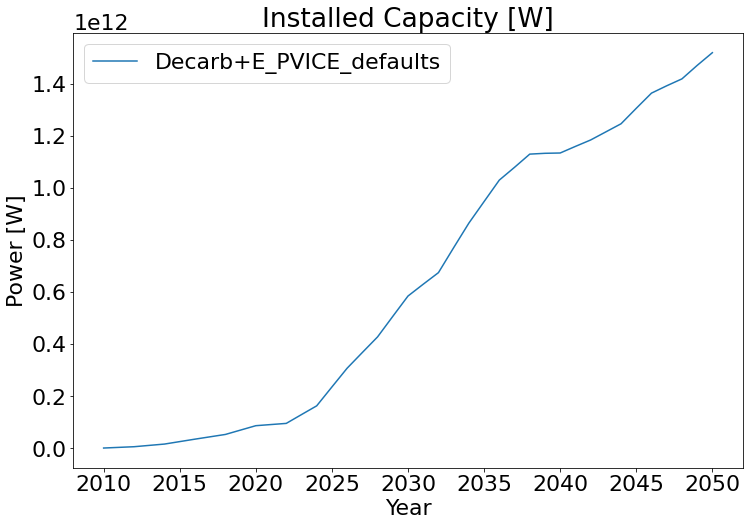

In [9]:
r1.plotScenariosComparison('Installed_Capacity_[W]')

## Lifetime and Recycling Scenario Creation

The range of potential future technology directions for PV will be explored in terms of module lifetime and EoL recycling rates. Currently technology is ~32 year module with a 6% EoL recycling rate (15% collection, 40% modules sent to recycling). Lifetimes could improve, with 50 years targeted by DOE SETO. And or recycling rates could improve, as modeled by CdTe management from First Solar or perovskite technology. This analysis will explore on a mass flow basis, which of these two circular economy levers is most important research priority for achieving the energy transition while minimizing waste and material extraction.

We will explore from a 15 year module lifetime to a 50 year module lifetime, and from 0% recycled to 100% recycled.

### Create lifetime and recycling ranges

In [30]:
Lifetime_Range = pd.concat([pd.Series(range(15,30,3)),pd.Series(range(30,51,2))]) #this absolute lifetime values
Lifetime_Range.reset_index(inplace=True, drop=True)
Lifetime_Diff30 = Lifetime_Range-30
Degradation_Range = pd.Series([1.470, 1.220, 1.050, 0.920, 0.820, 0.740, 0.690, 0.650, 0.615, 0.582, 0.555, 0.525, 0.505, 0.480, 0.460, 0.445])
Recycling_Range = pd.Series(range(0,105,5)) # this is absolute recycling values from 0-100
#print(Lifetime_Range)
#print(Degradation_Range)
#print(Recycling_Range)

In [47]:
#list of material recycling variables
RecyclingPaths = ['mat_MFG_scrap_Recycled', 'mat_MFG_scrap_Recycled_into_HQ', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 'mat_EOL_collected_Recycled', 'mat_EOL_Recycled_into_HQ', 'mat_EOL_RecycledHQ_Reused4MFG']
RecyclingYields = ['mat_MFG_scrap_Recycling_eff', 'mat_EOL_Recycling_eff']

Now some magic to automatically generate T50 and T90 values for each lifetime

In [32]:
#create linear regression for mod_reliability_t50 & mod_reliability_t90 vs. mod_lifetime 
#to estimate t50 and t90 values to input for improved lifetime scenario
reliability_baselines = pd.DataFrame()
reliability_baselines['mod_lifetime'] = r1.scenario['Decarb+E_PVICE_defaults'].data['mod_lifetime']
reliability_baselines['mod_reliability_t50'] = r1.scenario['Decarb+E_PVICE_defaults'].data['mod_reliability_t50']
reliability_baselines['mod_reliability_t90'] = r1.scenario['Decarb+E_PVICE_defaults'].data['mod_reliability_t90']

In [33]:
X_lifetime = reliability_baselines.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
Y1_t50 = reliability_baselines.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Y2_t90 = reliability_baselines.iloc[:, 2].values.reshape(-1, 1)
range_lifetimes = np.array(Lifetime_Range).reshape(-1,1)

from sklearn.linear_model import LinearRegression
from itertools import chain

linear_regressor_Y1 = LinearRegression()
linear_regressor_Y1.fit(X_lifetime, Y1_t50)  # perform linear regression
t50_list = linear_regressor_Y1.predict(range_lifetimes).tolist()  # make predictions based on improved lifetime values
t50_list = list(chain(*t50_list)) #unnest list
t50_range_simple = pd.Series([ '%.2f' % elem for elem in t50_list ])

linear_regressor_Y2 = LinearRegression() 
linear_regressor_Y2.fit(X_lifetime, Y2_t90)
t90_list = linear_regressor_Y2.predict(range_lifetimes).tolist()
t90_list = list(chain(*t90_list)) #unnest list
t90_range_simple = pd.Series([ '%.2f' % elem for elem in t90_list ])

In [34]:
#create a tidy dataframe summarizing all the lifetime, degradation, reliability values
lifetime_range_df = pd.concat([Lifetime_Range, Degradation_Range, t50_range_simple, t90_range_simple], axis=1)
lifetime_range_df.columns = 'mod_lifetime', 'mod_degradation', 't50', 't90'
print(lifetime_range_df)

    mod_lifetime  mod_degradation    t50    t90
0             15            1.470  13.95  19.78
1             18            1.220  17.56  23.15
2             21            1.050  21.17  26.53
3             24            0.920  24.78  29.90
4             27            0.820  28.39  33.28
5             30            0.740  32.00  36.65
6             32            0.690  34.41  38.90
7             34            0.650  36.81  41.15
8             36            0.615  39.22  43.40
9             38            0.582  41.63  45.65
10            40            0.555  44.03  47.90
11            42            0.525  46.44  50.15
12            44            0.505  48.85  52.40
13            46            0.480  51.25  54.65
14            48            0.460  53.66  56.90
15            50            0.445  56.07  59.15


In [35]:
#drop some of the higher lifetime values due to small value add and graphing
unnecessary = [48,46,42,38,34]
lifetime_range_df = lifetime_range_df[lifetime_range_df.mod_lifetime.isin(unnecessary)==False]
print(lifetime_range_df)

    mod_lifetime  mod_degradation    t50    t90
0             15            1.470  13.95  19.78
1             18            1.220  17.56  23.15
2             21            1.050  21.17  26.53
3             24            0.920  24.78  29.90
4             27            0.820  28.39  33.28
5             30            0.740  32.00  36.65
6             32            0.690  34.41  38.90
8             36            0.615  39.22  43.40
10            40            0.555  44.03  47.90
12            44            0.505  48.85  52.40
15            50            0.445  56.07  59.15


Now with the lifetime and recycling ranges defined, create a scenario for each combination

Notes:
- recycling values are set to closed loop, with XX% material recycling yields assuming 100% collection of modules and materials
- 

In [53]:
#these scenarios are being added onto the Decarb+E_PVICE_Default scenario
#All combinations of recycling and lifetime
for life in range(0,len(Lifetime_Range)): #loop over lifetimes
    for recycle in range (0,len(Recycling_Range)): #loop over recycling rates
        scenname = str(Lifetime_Range[life])+'years & '+ str(Recycling_Range[recycle])+'% Recycled' #name the scenario
        r1.createScenario(name=scenname,file=modulefile) #create the scenario with name
        #MODIFY LIFETIME PARAMETERS HERE
        r1.scenario[scenname].data['mod_lifetime'] = Lifetime_Range[life]
        r1.scenario[scenname].data['mod_reliability_t50'] = float(t50_range_simple[life])
        r1.scenario[scenname].data['mod_reliability_t90'] = float(t90_range_simple[life])
        r1.scenario[scenname].data['mod_degradation'] = Degradation_Range[life]
        #MODIFY Module RECYCLING PARAMATERS HERE
        #the assumption is all modules and materials are collected and sent to recycling, only material recycling yields vary
        r1.scenario[scenname].data['mod_EOL_collected_recycled'] = 100.0
        r1.scenario[scenname].data['mod_EOL_collection_eff'] =100.0
        
        #Add Materials to scenario
        for mat in range (0,len(MATERIALS)):
            materialfile = 'baseline_material_'+ MATERIALS[mat] +'.csv' #name the material file
            materialfile = os.path.join(materialsfolder,materialfile) #point at the material file in the baselines folder
            r1.scenario[scenname].addMaterial(MATERIALS[mat], file=materialfile)
            
            #remove 1995-2009 from each material
            matdf = r1.scenario[scenname].material[MATERIALS[mat]].materialdata #pull out the df
            matdf.set_index('year', inplace=True) #assign the year index to the df
            matdf.drop(matdf.loc['1995':'2009'].index, inplace=True) #drop the early years
            r1.scenario[scenname].material[MATERIALS[mat]].materialdata = matdf #reassign the material data to the simulation
            
            #Modify Material recycling parameters for 2021 and forward
            for var in range(0,len(RecyclingPaths)):
                r1.scenario[scenname].material[MATERIALS[mat]].materialdata[RecyclingPaths[var]].loc[2021:] = 100.0
            for ylds in range(0,len(RecyclingYields)):
                r1.scenario[scenname].material[MATERIALS[mat]].materialdata[RecyclingYields[ylds]].loc[2021:] = Recycling_Range[recycle]
            
            

In [60]:
print(len(r1.scenario.keys()))

337


In [ ]:
r1.calculateMassFlow()

Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working o

==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Wo

==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  27years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

==> Working on Material :  backsheet
Working on Scenario:  30years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Worki

Working on Scenario:  32years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W